In [198]:
import sys  
import time  
import math  
import uuid  
import numpy as np  
import matplotlib.pyplot as plt
import pickle
import plotly.graph_objs as go
from numpy import errstate  
from sklearn.datasets import fetch_openml  
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import OneHotEncoder  
from tqdm import tqdm

In [199]:
sys.setrecursionlimit(10000)  

In [200]:
class VarValue:
    def __init__(self, value, children=(), varname=''):
        self.varname = varname
        self.value = value
        self.derivative_to = {}
        self.children = children

    def __chain_rule(self, dSelfdx, child):
        if(child.varname[:5] != 'const'):
            for grandchild_varname in child.derivative_to:
                if(grandchild_varname != 'const'):
                    if(grandchild_varname in self.derivative_to):

                        self.derivative_to[grandchild_varname] += dSelfdx * child.derivative_to[grandchild_varname]
                    else:
                        self.derivative_to[grandchild_varname] = dSelfdx * child.derivative_to[grandchild_varname]
            if(len(self.derivative_to) == 0):
              raise ValueError(self.varname, child.varname)

    def relu(self):
        out = VarValue(max(0,self.value), children=(self,), varname='out_relu_'+str(uuid.uuid4()))
        if(self.varname[:5] != 'const'):
            dodx = 0 if self.value <= 0 else 1
            if(len(self.children) == 0):
                out.derivative_to[self.varname] = dodx
            else:
                out.__chain_rule(dodx, self)
        return out

    def ln(self):
        out = VarValue(math.log(self.value), children=(self,), varname='out_ln_'+str(uuid.uuid4()))
        if(self.varname[:5] != 'const'):
            dodx = 1/(self.value)
            if(len(self.children) == 0):
                out.derivative_to[self.varname] = dodx
            else:
                out.__chain_rule(dodx, self)
        return out

    def __mul__(self, other):
        other = other if isinstance(other, VarValue) else VarValue(other, varname='const'+str(uuid.uuid4()))
        out = VarValue(self.value * other.value, children=(self, other), varname='out_mul_'+str(uuid.uuid4()))

        if(self.varname[:5] != 'const'):
            dodx1 = other.value
            if(len(self.children) == 0):
                out.derivative_to[self.varname] = dodx1
            else:
                out.__chain_rule(dodx1, self)
        if(other.varname[:5] != 'const'):
            dodx2 = self.value
            if(len(other.children) == 0):
                out.derivative_to[other.varname] = dodx2
            else:
                out.__chain_rule(dodx2, other)
        return out

    def __add__(self, other):
        other = other if isinstance(other, VarValue) else VarValue(other, varname='const'+str(uuid.uuid4()))
        out = VarValue(self.value + other.value, children=(self, other), varname='out_add_'+str(uuid.uuid4()))
        if(self.varname[:5] != 'const'):
            dodx1 = 1
            if(len(self.children) == 0):
                out.derivative_to[self.varname] = dodx1
            else:
                out.__chain_rule(dodx1, self)
        if(other.varname[:5] != 'const'):
            dodx2 = 1
            if(len(other.children) == 0):
                out.derivative_to[other.varname] = dodx2
            else:
                out.__chain_rule(dodx2, other)
        return out

    def __sub__(self, other):
        return self + (-other)

    def __truediv__(self, other):
        return self * other**-1

    def __neg__(self):
        return self * -1

    def __pow__(self, other):
        other = other if isinstance(other, VarValue) else VarValue(other, varname='const'+str(uuid.uuid4()))
        try:
            with errstate(over='raise', invalid='raise'):
                result = float(self.value) ** float(other.value)
        except (OverflowError, FloatingPointError):
            if abs(float(self.value)) > 1:
                result = math.inf
            else:
                result = 0

        out = VarValue(result, children=(self, other), varname='out_pow_'+str(uuid.uuid4()))

        if(self.varname[:5] != 'const'):
            dodx = other.value * self.value**(other.value-1)
            if(len(self.children) == 0):
                out.derivative_to[self.varname] = dodx
            else:
                out.__chain_rule(dodx, self)
        return out

    def __rmul__(self, other):
        return self * other

    def __radd__(self, other):
        return self + other

    def __rsub__(self, other):
        return other + (-self)

    def __rpow__(self, other):
        other = other if isinstance(other, VarValue) else VarValue(other, varname='const'+str(uuid.uuid4()))
        out = VarValue(other.value**self.value, children=(self, other), varname='out_rpow_'+str(uuid.uuid4()))
        if self.varname:
            dodx = other.value**self.value * math.log(other.value)
            if(len(self.children) == 0):
                out.derivative_to[self.varname] = dodx
            else:
                out.__chain_rule(dodx, self)
        return out

    def __rtruediv__(self, other):
        return other * self**-1

    # Equality
    def __eq__(self, other):
        if isinstance(other, VarValue):
            return self.varname == other.varname
        return self.varname == other

    # Inequality
    def __ne__(self, other):
        return not self.__eq__(other)

    # Less than
    def __lt__(self, other):
        if isinstance(other, VarValue):
            return self.value < other.value
        return self.value < other

    # Less than or equal
    def __le__(self, other):
        if isinstance(other, VarValue):
            return self.value <= other.value
        return self.value <= other

    # Greater than
    def __gt__(self, other):
        if isinstance(other, VarValue):
            return self.value > other.value
        return self.value > other

    # Greater than or equal
    def __ge__(self, other):
        if isinstance(other, VarValue):
            return self.value >= other.value
        return self.value >= other
    
    def log(self):
        out = VarValue(math.log(self.value), children=(self,), varname='outlog'+str(uuid.uuid4()))
        if self.varname[:5] != 'const':
            dodx = 1 / self.value
            if len(self.children) == 0:
                out.derivative_to[self.varname] = dodx
            else:
                out.__chain_rule(dodx, self)
        return out

    def exp(self):
        out = VarValue(math.exp(self.value), children=(self,), varname='out_exp_'+str(uuid.uuid4()))
        if self.varname[:5] != 'const':
            dodx = math.exp(self.value)
            if len(self.children) == 0:
                out.derivative_to[self.varname] = dodx
            else:
                out.__chain_rule(dodx, self)
        return out



In [201]:
class Layer:
    def __init__(self,n_neurons=3, init='zero', activation='relu', weights=None, biases=None):
        # weights & biases ditambah di init buat memfasilitasi loading weight & bias
        self.n_neurons = n_neurons
        self.current_input_batch = None
        self.init = init    # zero/uniform/normal/xavier/he - harusnya gaperlu disini, ini di layer langsung harusnya
        self.weights = weights
        self.biases = biases
        self.activation = activation    # linear/relu/sigmoid/tanh/softmax/binary_step/leaky_relu/prelu/elu/swish(ini)/gelu(ini)
        self.learning_rate = None

        self.grad_weights = None
        self.grad_biases = None 

        self.net = None
        self.out = None

    def __update_weights_dEdW(self, dEdW):
        clip_value = 1.0  # maksimal update yang diperbolehkan
        dEdW = np.clip(dEdW, -clip_value, clip_value)
        self.weights -= self.learning_rate * dEdW

    def __update_biases_dEdB(self, dEdB):
        clip_value = 1.0  # maksimal update yang diperbolehkan
        dEdB = np.clip(dEdB, -clip_value, clip_value)
        self.biases -= self.learning_rate * dEdB

    def __update_weights_err_term(self, err_term):
        for input in self.current_input_batch:
            for i in self.weights:
                for j in i:
                    self.weights += self.learning_rate*err_term[j]*self.input[i]

    def __update_biases_err_term(self, err_term):
        for i in self.weights:
            for j in i:
                self.weights += self.learning_rate*err_term[j]*1

    def forward(self, current_input_batch):
        self.current_input_batch = current_input_batch

        if(self.weights is None):
            
            if(self.init == 'zero'):
                self.weights = np.array([[VarValue(0,varname='w_'+str(uuid.uuid4())) for _ in range(self.n_neurons)] for _ in range(len(self.current_input_batch[0]))])
                self.biases = np.array([VarValue(0,varname='b_'+str(uuid.uuid4())) for _ in range(self.n_neurons)])
                print("TESTT")
                print(self.weights)
                print(self.biases)

            # Ini semua diround soalnya hasil operasinya kegedean, kena warning wkwkwk. CMIIW yh harusnya berapa angka di belakang koma - @evelynnn04

            elif(self.init == 'uniform'):
                limit = 1 / np.sqrt(len(self.current_input_batch[0]))
                self.weights = np.array([[VarValue(round(np.random.uniform(-limit, limit), 4), varname='w_'+str(uuid.uuid4())) 
                                        for _ in range(self.n_neurons)] for _ in range(len(self.current_input_batch[0]))])
                self.biases = np.array([VarValue(round(np.random.uniform(-limit, limit), 4), varname='b_'+str(uuid.uuid4())) 
                                        for _ in range(self.n_neurons)])

            elif self.init == 'normal':
                std = 1 / np.sqrt(len(self.current_input_batch[0]))
                self.weights = np.array([[VarValue(round(np.random.normal(0, std), 4), varname='w_'+str(uuid.uuid4())) 
                                        for _ in range(self.n_neurons)] for _ in range(len(self.current_input_batch[0]))])
                self.biases = np.array([VarValue(round(np.random.normal(0, std), 4), varname='b_'+str(uuid.uuid4())) 
                                        for _ in range(self.n_neurons)])

            elif self.init == 'xavier':
                std = np.sqrt(2 / (len(self.current_input_batch[0]) + self.n_neurons))
                self.weights = np.array([[VarValue(round(np.random.normal(0, std), 4), varname='w_'+str(uuid.uuid4())) 
                                        for _ in range(self.n_neurons)] for _ in range(len(self.current_input_batch[0]))])
                self.biases = np.array([VarValue(round(0, 4), varname='b_'+str(uuid.uuid4())) 
                                        for _ in range(self.n_neurons)])

            elif self.init == 'he':
                std = np.sqrt(2 / len(self.current_input_batch[0]))
                self.weights = np.array([[VarValue(round(np.random.normal(0, std), 4), varname='w_'+str(uuid.uuid4())) 
                                        for _ in range(self.n_neurons)] for _ in range(len(self.current_input_batch[0]))])
                self.biases = np.array([VarValue(round(0, 4), varname='b_'+str(uuid.uuid4())) 
                                        for _ in range(self.n_neurons)])


        self.net = (np.dot(self.current_input_batch, self.weights)) + self.biases

        if(self.activation == 'linear'):
            self.out = self.net

        elif(self.activation == 'relu'):
            self.out = np.array([[net.relu() for net in row] for row in self.net])

        elif(self.activation == 'sigmoid'):
            for i in self.net:
                for j in i:
                    j.value = np.clip(j.value, -500, 500)
            self.out = 1 / (1 + (math.exp(1))**(-self.net))

        elif(self.activation == 'tanh'):
            self.out = (math.exp(1)**self.net - math.exp(1)**(-self.net))/(math.exp(1)**self.net + math.exp(1)**(-self.net))

        elif self.activation == 'softmax':
            exp_values = np.array([[net.exp() for net in row] for row in self.net])
            sums = np.array([[VarValue(sum(n.value for n in row), varname='sum_exp_'+str(uuid.uuid4()))] for row in exp_values])
            self.out = np.array([[exp_values[i][j] / sums[i][0] for j in range(len(exp_values[i]))] for i in range(len(exp_values))])


    def backward(self, err=None):
        if err is None:
            raise ValueError("err (VarValue object) harus diberikan dari fungsi loss sebagai parameter!")

        # Ambil derivatif langsung dari err (loss)
        dEdW = np.zeros((len(self.weights), len(self.weights[0])))
        dEdB = np.zeros(len(self.biases))

        for i in range(len(self.weights)):
            for j in range(len(self.weights[i])):
                varname = self.weights[i][j].varname
                dEdW[i][j] = err.derivative_to.get(varname, 0.0)

        for j in range(len(self.biases)):
            varname = self.biases[j].varname
            dEdB[j] = err.derivative_to.get(varname, 0.0)

        # Simpan gradien
        self.grad_weights = dEdW
        self.grad_biases = dEdB

        # Update bobot dan bias
        clip_val = 1.0
        self.weights -= self.learning_rate * np.clip(dEdW, -clip_val, clip_val)
        self.biases -= self.learning_rate * np.clip(dEdB, -clip_val, clip_val)


    def clean_derivative(self):
        for input in self.current_input_batch:
            for x in input:
                x.derivative_to.clear()
                x.children = ()

        for i in self.weights:
            for j in i:
                j.derivative_to.clear()
                j.children = ()

        for b in self.biases:
            b.derivative_to ={}
            b.children = ()

        for i in self.net:
            for j in i:
                j.derivative_to.clear()
                j.children = ()

        for i in self.out:
            for j in i:
                j.derivative_to.clear()
                j.children = ()

In [202]:
class FFNN:
    def __init__(self, loss='mse', batch_size=1, learning_rate=0.01, epochs=20, verbose=0):
        self.loss = loss    # mse/bce/cce
        self.batch_size=batch_size
        self.learning_rate=learning_rate
        self.epochs=epochs
        self.verbose=verbose
        self.layers = None
        self.weights = []
        self.bias = []
        self.x = None
        self.y = None
        self.onehot_encoder = OneHotEncoder(categories='auto')

    def __loss(self, out, target):
        if out.shape != target.shape:
            print("Output shape: ", out.shape)
            print("Target shape: ", target.shape)
            raise ValueError("Shape not match")

        if self.loss == 'mse':
            mse = (1/target.shape[1]) * np.square(target - out)
            return np.sum(mse)

        elif self.loss == 'bce':
            epsilon = 1e-15
            # loss = VarValue(0.0, varname='loss_bce')
            loss = 0

            for i in range(target.shape[0]):            # loop untuk batch
                for j in range(target.shape[1]):        # loop untuk neuron output
                    # target_val = VarValue(target[i, j], varname=f'target_{i}_{j}')

                    # Clipping untuk mencegah log(0)
                    out[i, j].value = np.clip(out[i, j].value, epsilon, 1 - epsilon)

                    # BCE: -(y*log(p) + (1-y)*log(1-p))
                    term1 = target * out[i, j].log()
                    term2 = (1 - target) * (1 - out[i, j]).log()

                    loss = loss + (term1 + term2)

            loss = loss * (-1 / self.batch_size)
            return loss

        elif self.loss == 'cce':
            epsilon = 1e-15
            loss = VarValue(0.0, varname='loss_const')

            for i in range(target.shape[0]):            # loop untuk batch
                for j in range(target.shape[1]):        # loop untuk neuron output
                    target_val = VarValue(target[i, j], varname=f'target_{i}_{j}')
                    out[i, j].value = np.clip(out[i, j].value, epsilon, 1 - epsilon)
                    loss = loss + (target_val * out[i, j].log())

            loss = loss * (-1 / self.batch_size)
            return loss

    def build_layers(self, *layers: Layer):
        self.layers = layers
        for layer in self.layers:
            layer.learning_rate = self.learning_rate

    def fit(self, x, y, validation_data=None):
        self.x = x
        self.y = self.onehot_encoder.fit_transform(y.reshape(-1, 1)).toarray()
        
        history = {'train_loss': [], 'val_loss': []}
        
        total_batch = (len(x) + self.batch_size - 1) // self.batch_size
        start_global = time.time()

        epoch_iterator = tqdm(range(self.epochs), desc="Training Progress", unit="epoch") if self.verbose else range(self.epochs)

        for epoch in epoch_iterator:
            train_loss_epoch = 0.0

            batch_iterator = tqdm(range(total_batch), desc=f"Epoch {epoch + 1}", unit="batch", leave=False) if self.verbose else range(total_batch)

            for i in batch_iterator:
                x_batch = self.x[i * self.batch_size:(i + 1) * self.batch_size] if (i + 1) < total_batch else self.x[i * self.batch_size:]
                y_batch = self.y[i * self.batch_size:(i + 1) * self.batch_size] if (i + 1) < total_batch else self.y[i * self.batch_size:]

                # Forward pass
                batch_input = x_batch
                for layer in self.layers:
                    layer.forward(batch_input)
                    batch_input = layer.out
                out = batch_input

                # Hitung loss
                error = self.__loss(out, y_batch)
                train_loss_epoch += error.value if isinstance(error, VarValue) else error

                # Backward pass
                for layer in reversed(self.layers):
                    layer.backward(err=error)

                for layer in self.layers:
                    layer.clean_derivative()

            # Rata-rata training loss per epoch
            avg_train_loss = train_loss_epoch / total_batch
            history['train_loss'].append(avg_train_loss)

            # Jika ada data validasi, hitung validation loss
            if validation_data:
                X_val, y_val = validation_data
                y_val_enc = self.onehot_encoder.transform(y_val.reshape(-1, 1)).toarray()
                val_pred = self.predict(X_val)
                val_loss = self.__loss(val_pred, y_val_enc)
                avg_val_loss = val_loss.value if isinstance(val_loss, VarValue) else val_loss
                history['val_loss'].append(avg_val_loss)

            if self.verbose:
                print(f"Epoch {epoch+1}/{self.epochs}, Train Loss: {avg_train_loss:.4f}", end="")
                if validation_data:
                    print(f", Validation Loss: {avg_val_loss:.4f}")
                else:
                    print()

        end_global = time.time()
        print("Total Duration:", end_global - start_global)

        return history

    def predict(self, x_predict):
        batch_input = x_predict
        for layer in self.layers:
            layer.forward(batch_input)
            batch_input = layer.out
        out = batch_input
        return out
        
    def visualize(self):
        num_layers = len(self.layers)

        # Warna untuk setiap layer
        layer_colors = {
            0: 'yellow',    # Input layer
            -1: 'salmon',   # Output layer
            'hidden': 'lightblue'  # Hidden layers
        }

        nodes_x, nodes_y, node_colors, node_texts = [], [], [], []

        # Membuat koordinat dan informasi node
        for layer_idx, layer in enumerate(self.layers):
            if num_layers == 1:
                color = layer_colors[-1]
            elif layer_idx == 0:
                color = layer_colors[0]
            elif layer_idx == num_layers - 1:
                color = layer_colors[-1]
            else:
                color = layer_colors['hidden']

            n_neurons = layer.n_neurons
            y_positions = np.linspace(0, 1, n_neurons)
            x_pos = layer_idx / (num_layers - 1) if num_layers > 1 else 0.5

            for neuron_idx, y_pos in enumerate(y_positions):
                nodes_x.append(x_pos)
                nodes_y.append(y_pos)
                node_colors.append(color)

                node_info = f"Layer {layer_idx}, Neuron {neuron_idx}<br>Activation: {layer.activation}"

                # Menampilkan gradient dari bias jika tersedia
                if layer.grad_biases is not None:
                    node_info += f"<br>Bias Gradient: {layer.grad_biases[neuron_idx]:.4f}"
                else:
                    node_info += "<br>Bias Gradient: N/A"

                node_texts.append(node_info)

        # Membuat node scatter plot
        node_trace = go.Scatter(
            x=nodes_x, y=nodes_y,
            mode='markers',
            hoverinfo='text',
            marker=dict(
                showscale=False,
                color=node_colors,
                size=15,
                line_width=2
            ),
            text=node_texts
        )

        # Membuat edge scatter plot terpisah untuk tiap koneksi (agar hoverable)
        edge_traces = []

        for layer_idx, layer in enumerate(self.layers[:-1]):
            next_layer = self.layers[layer_idx + 1]
            x_pos = layer_idx / (num_layers - 1)
            next_x = (layer_idx + 1) / (num_layers - 1)

            y_positions = np.linspace(0, 1, layer.n_neurons)
            next_y_positions = np.linspace(0, 1, next_layer.n_neurons)

            for curr_neuron_idx, curr_y in enumerate(y_positions):
                for next_neuron_idx, next_y in enumerate(next_y_positions):

                    # Informasi bobot dan gradient bobot
                    weight_text = "Weight: Not initialized"
                    gradient_text = "Gradient: N/A"

                    if layer.weights is not None:
                        try:
                            weight = next_layer.weights[curr_neuron_idx][next_neuron_idx].value
                            weight_text = f"Weight: {weight:.4f}"
                        except:
                            weight_text = "Weight: Unavailable"

                    if layer.grad_weights is not None:
                        try:
                            gradient = next_layer.grad_weights[curr_neuron_idx][next_neuron_idx]
                            gradient_text = f"Gradient: {gradient:.4f}"
                        except:
                            gradient_text = "Gradient: Unavailable"

                    edge_trace = go.Scatter(
                        x=[x_pos, next_x],
                        y=[curr_y, next_y],
                        mode='lines+markers',
                        line=dict(width=0.5, color='#888'),
                        hoverinfo='text',
                        text=f"{weight_text}<br>{gradient_text}",
                        marker=dict(size=10, opacity=0) # marker transparan tapi hoverable
                    )

                    edge_traces.append(edge_trace)

        # Buat figure dengan nodes dan edges
        fig = go.Figure(data=edge_traces + [node_trace],
                        layout=go.Layout(
                            title='Neural Network Architecture',
                            showlegend=False,
                            hovermode='closest',
                            margin=dict(b=0,l=0,r=0,t=40),
                            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                            plot_bgcolor='rgba(255,255,255,255)'
                        ))
        fig.show()


    
    def save(self, filename):
        model_data = {
            'loss': self.loss,
            'batch_size': self.batch_size,
            'learning_rate': self.learning_rate,
            'epochs': self.epochs,
            'layers': [
                {'n_neurons': layer.n_neurons, 'activation': layer.activation, 'weights': layer.weights.tolist(), 'biases': layer.biases.tolist()}
                for layer in self.layers
            ]
        }
        with open(filename, 'wb') as f:
            pickle.dump(model_data, f)
        print(f"Model saved to {filename}")

    def load(self, filename):
        with open(filename, 'rb') as f:
            model_data = pickle.load(f)
        self.loss = model_data['loss']
        self.batch_size = model_data['batch_size']
        self.learning_rate = model_data['learning_rate']
        self.epochs = model_data['epochs']
        self.layers = [
            Layer(n_neurons=layer['n_neurons'], activation=layer['activation'], weights=np.array(layer['weights']), biases=np.array(layer['biases']))
            for layer in model_data['layers']
        ]
        print(f"Model loaded from {filename}")
    
    def plot_weights_distribution(self, layers_to_plot):
        num_layers = len(layers_to_plot)
        plt.figure(figsize=(6*num_layers, 4))
        
        for idx, layer_idx in enumerate(layers_to_plot):
            layer = self.layers[layer_idx]
            weights_values = [w.value for neuron_weights in layer.weights for w in neuron_weights]

            plt.subplot(1, num_layers, idx + 1)
            plt.hist(weights_values, bins=5, color='lightblue', alpha=0.7)
            plt.title(f'Distribusi Bobot Layer {layer_idx+1}')
            plt.xlabel('Nilai Bobot')
            plt.ylabel('Frekuensi')

        plt.tight_layout()
        plt.show()

    def plot_gradients_distribution(self, layers_to_plot):
        num_layers = len(layers_to_plot)
        plt.figure(figsize=(6*num_layers, 4))
        
        for idx, layer_idx in enumerate(layers_to_plot):
            layer = self.layers[layer_idx]
            gradients_values = [gw for grad_weights in layer.grad_weights for gw in grad_weights]

            plt.subplot(1, num_layers, idx + 1)
            plt.hist(gradients_values, bins=5, color='lightpink', alpha=0.7)
            plt.title(f'Distribusi Gradien Layer {layer_idx+1}')
            plt.xlabel('Nilai Gradien')
            plt.ylabel('Frekuensi')

        plt.tight_layout()
        plt.show()


In [203]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
y = y.astype(np.uint8)

In [204]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=65500,
    train_size=10,
    random_state=42,
    stratify=y
)

In [205]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [206]:
X_train = np.array([[VarValue(x, varname='x_'+str(uuid.uuid4())) for x in row] for row in X_train])

In [207]:
model_ffnn = FFNN(
    loss='cce',
    batch_size=1,
    learning_rate=0.1,
    epochs=2,
    verbose=1,
)

In [208]:
model_ffnn.build_layers(
    Layer(n_neurons=4, init='uniform', activation='relu'),
    Layer(n_neurons=3, init='uniform', activation='relu'),
    Layer(n_neurons=2, init='uniform', activation='relu'),
    Layer(n_neurons=10, init='uniform', activation='softmax')
)

In [209]:
model_ffnn.fit(X_train, y_train)

Training Progress:  50%|█████     | 1/2 [00:07<00:07,  7.16s/epoch]

Epoch 1/2, Train Loss: 2.4427


Training Progress: 100%|██████████| 2/2 [00:14<00:00,  7.16s/epoch]

Epoch 2/2, Train Loss: 2.4366
Total Duration: 14.328763723373413


{'train_loss': [2.4427407720373218, 2.4366345371709164], 'val_loss': []}

In [210]:
model_ffnn.visualize()

In [211]:
for layer in model_ffnn.layers:
    print("=====Layer======")
    for i in range(len(layer.weights)):
        print("==Neuron==")
        for j in range(len(layer.weights[0])):
            print(f"[{i}][{j}]{layer.weights[i][j].value}")

=====Layer======
==Neuron==
[0][0]0.021
[0][1]0.0036
[0][2]-0.011
[0][3]0.0143
==Neuron==
[1][0]-0.0338
[1][1]0.0212
[1][2]0.0137
[1][3]0.0165
==Neuron==
[2][0]0.0152
[2][1]0.0065
[2][2]0.0224
[2][3]-0.0196
==Neuron==
[3][0]-0.0315
[3][1]0.0156
[3][2]0.0065
[3][3]0.0177
==Neuron==
[4][0]-0.0052
[4][1]-0.0252
[4][2]0.0046
[4][3]-0.0238
==Neuron==
[5][0]0.0217
[5][1]-0.0056
[5][2]-0.0115
[5][3]-0.0335
==Neuron==
[6][0]-0.0328
[6][1]0.0087
[6][2]0.0025
[6][3]-0.029
==Neuron==
[7][0]-0.0141
[7][1]0.0281
[7][2]-0.0293
[7][3]-0.0248
==Neuron==
[8][0]-0.0208
[8][1]-0.0153
[8][2]-0.0082
[8][3]0.008
==Neuron==
[9][0]-0.03
[9][1]-0.0282
[9][2]-0.0174
[9][3]-0.006
==Neuron==
[10][0]0.0303
[10][1]-0.0137
[10][2]0.0179
[10][3]-0.034
==Neuron==
[11][0]0.0027
[11][1]-0.0282
[11][2]0.0039
[11][3]-0.0027
==Neuron==
[12][0]-0.0072
[12][1]0.019
[12][2]-0.0307
[12][3]-0.0213
==Neuron==
[13][0]0.0057
[13][1]0.0187
[13][2]-0.0314
[13][3]0.0046
==Neuron==
[14][0]0.0339
[14][1]0.0085
[14][2]0.0297
[14][3]-0.0

In [212]:
for layer in model_ffnn.layers:
    for i in layer.weights:
        for j in i:
            print(j.value)

0.021
0.0036
-0.011
0.0143
-0.0338
0.0212
0.0137
0.0165
0.0152
0.0065
0.0224
-0.0196
-0.0315
0.0156
0.0065
0.0177
-0.0052
-0.0252
0.0046
-0.0238
0.0217
-0.0056
-0.0115
-0.0335
-0.0328
0.0087
0.0025
-0.029
-0.0141
0.0281
-0.0293
-0.0248
-0.0208
-0.0153
-0.0082
0.008
-0.03
-0.0282
-0.0174
-0.006
0.0303
-0.0137
0.0179
-0.034
0.0027
-0.0282
0.0039
-0.0027
-0.0072
0.019
-0.0307
-0.0213
0.0057
0.0187
-0.0314
0.0046
0.0339
0.0085
0.0297
-0.0111
-0.0097
0.0243
0.009
-0.0257
-0.0153
-0.0316
0.0168
-0.0162
-0.0342
-0.0351
0.025
0.0105
0.0145
0.011
-0.0295
-0.0163
0.0123
0.0015
-0.0299
-0.0062
-0.0161
-0.0025
-0.0064
-0.0146
-0.0116
-0.0349
0.0346
-0.0173
-0.0221
0.0157
0.001
0.0171
0.0299
0.0325
0.0273
-0.0059
-0.0068
0.0104
-0.0348
0.0011
0.0256
0.0094
0.0124
-0.0186
-0.0211
-0.0259
0.0185
-0.004
0.0205
-0.0031
-0.0084
0.0177
0.0015
-0.0228
-0.015
-0.0002
-0.0232
0.0356
-0.0072
0.0344
-0.0143
-0.0343
-0.0119
0.0334
-0.0159
-0.0014
0.0048
0.0016
0.0294
0.0085
0.0137
0.0209
-0.0195
-0.0196
-0.008

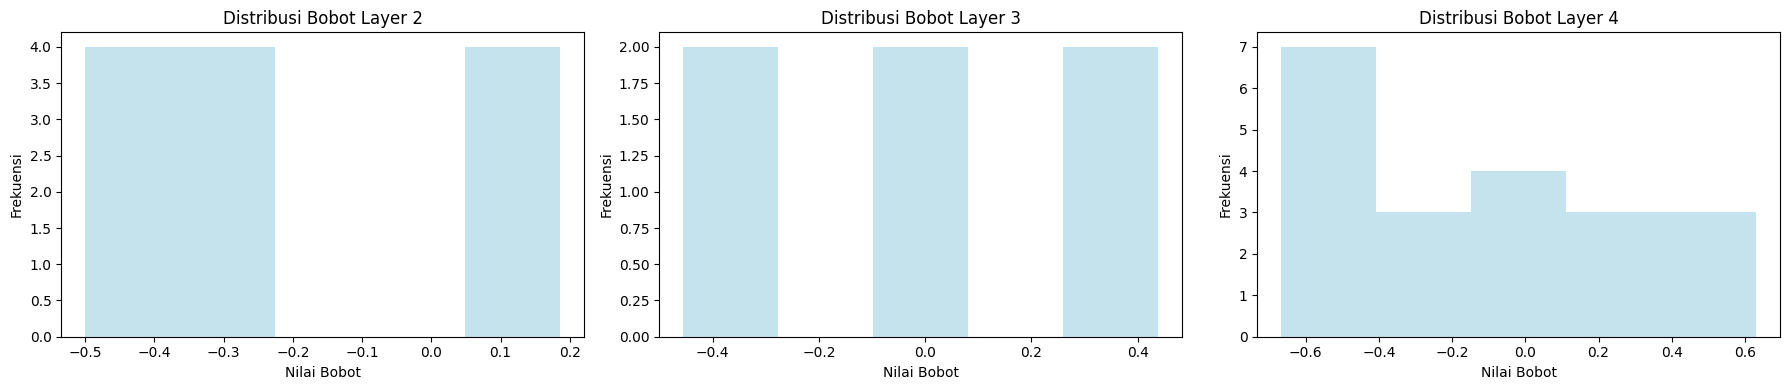

In [213]:
model_ffnn.plot_weights_distribution(layers_to_plot=[1,2,3])

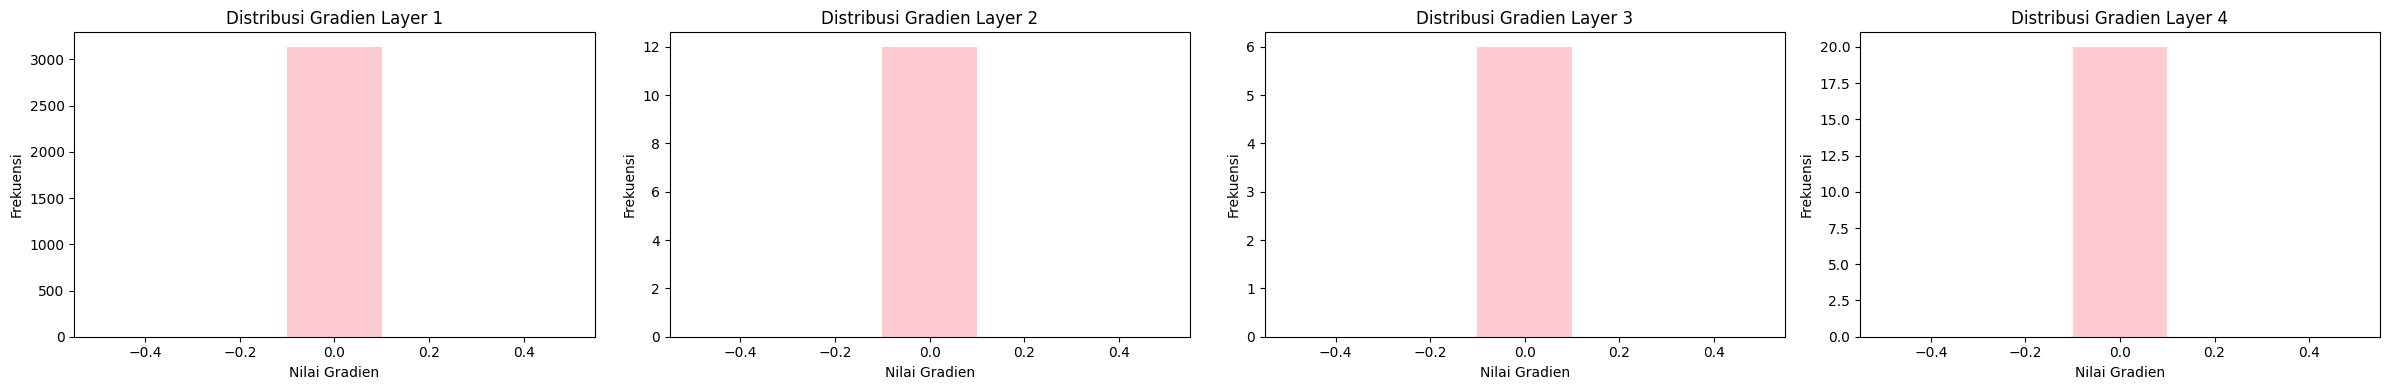

In [214]:
model_ffnn.plot_gradients_distribution(layers_to_plot=[0, 1, 2, 3])

In [215]:
y_pred = model_ffnn.predict(X_test[:10])
for h in y_pred:
    max_index = np.argmax(h)
    print(max_index)

6
6
6
6
6
6
6
6
6
6


In [216]:
model_ffnn.y.shape

(10, 10)

In [217]:
for h in y_test[:10].flatten():
    print(h)

9
6
5
9
6
9
8
8
1
2


In [218]:
model_ffnn.save(filename="try1.pth")

Model saved to try1.pth


In [219]:
new_model = FFNN()
new_model.load(filename="try1.pth")

Model loaded from try1.pth


In [220]:
y_pred = new_model.predict(X_test[:10])
for h in y_pred:
    max_index = np.argmax(h)
    print(max_index)

6
6
6
6
6
6
6
6
6
6


In [221]:
# TESTING AJA KALAU ADA VALIDATION DATA, I WANNA C IF THE LOST TERSIMPAN

history = model_ffnn.fit(X_train, y_train, validation_data=(X_test[:10], y_test[:10]))

Training Progress:  50%|█████     | 1/2 [00:10<00:10, 10.83s/epoch]

Epoch 1/2, Train Loss: 2.4246, Validation Loss: 24.6311


Training Progress: 100%|██████████| 2/2 [00:21<00:00, 10.97s/epoch]

Epoch 2/2, Train Loss: 2.4245, Validation Loss: 24.6288
Total Duration: 21.94669222831726


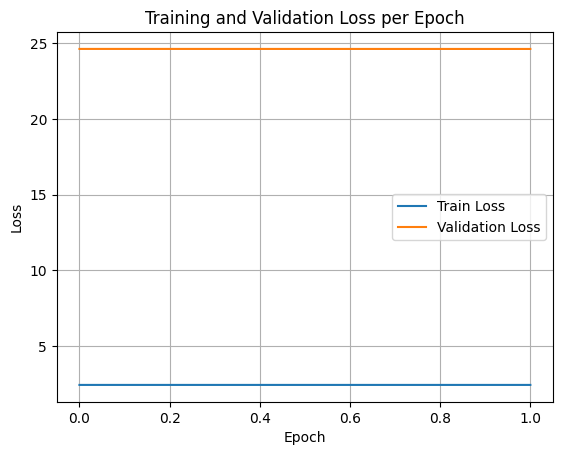

In [222]:
# Visualisasi loss
import matplotlib.pyplot as plt

plt.plot(history['train_loss'], label='Train Loss')
if history['val_loss']:
    plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()